# Analysis of Crime occurence in Vancouver City from 2013 to 2022
#### University of British Columbia
#### ECON 323-004 2022W2 Final Project 

Collabrators and Contributions:
- Yiming Li(Student number: 52680360): I am accountable for ideating the overarching
concept of the project, formulating the research objectives. Do the Visualization part and leveraging python code
to construct and evaluate the time series model.
- Pengchao Chen(Student number: 31253933): I contributed to the project by coding and
writing content, as well as building and selecting Time-Series models.
- Sawyer Wang(Student number: 63591192): Providing the draft of proposal, searching
the datafile and taking the responsibility of cleaning data and representing data.
- Zhihao Wu(Student number: 56834187): Writing the introduction and conclusion, helping
modify the code and annotate the coding.


## 1. Introduction:

## 2. Literature Review:

## 3. Data Pre-Processing

### A) Load Data-set

In [1]:
# Load package
! pip install -q pyproj
! pip install -q folium
import folium
import pandas as pd
import numpy as np
from pyproj import Proj
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter1d

# model building package
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
! pip install -q pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

In [2]:
# Load dataset
df_original = pd.read_csv('crimedata_csv_AllNeighbourhoods_AllYears.csv')
df_original.head()

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
0,Other Theft,2015,5,7,12,50,7XX DUNSMUIR ST,Central Business District,491511.6366,5.459024e+06
1,Other Theft,2015,5,13,17,0,7XX DUNSMUIR ST,Central Business District,491511.6366,5.459024e+06
2,Other Theft,2015,5,16,10,45,7XX DUNSMUIR ST,Central Business District,491511.6366,5.459024e+06
3,Other Theft,2015,5,17,18,45,7XX DUNSMUIR ST,Central Business District,491511.6366,5.459024e+06
4,Other Theft,2015,5,18,20,10,7XX DUNSMUIR ST,Central Business District,491511.6366,5.459024e+06


In [3]:
# Print out the column names, their data types, and count of non-NA values
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857259 entries, 0 to 857258
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TYPE           857259 non-null  object 
 1   YEAR           857259 non-null  int64  
 2   MONTH          857259 non-null  int64  
 3   DAY            857259 non-null  int64  
 4   HOUR           857259 non-null  int64  
 5   MINUTE         857259 non-null  int64  
 6   HUNDRED_BLOCK  857247 non-null  object 
 7   NEIGHBOURHOOD  857116 non-null  object 
 8   X              857186 non-null  float64
 9   Y              857186 non-null  float64
dtypes: float64(2), int64(5), object(3)
memory usage: 65.4+ MB


In [4]:
# Check if the dataset contains any missing value
df_original.isnull().values.any()

True

In [5]:
# Count the number of missing values for each column
df_original.isnull().sum()

TYPE               0
YEAR               0
MONTH              0
DAY                0
HOUR               0
MINUTE             0
HUNDRED_BLOCK     12
NEIGHBOURHOOD    143
X                 73
Y                 73
dtype: int64

### B) Data Wrangling

In [6]:
# Drop the rows of missing values and check again if the dataset still contains missing value
df_original_drop = df_original.dropna()
df_original_drop.isnull().values.any()

False

In [7]:
# Drop Day, Hour, Minute columns
df = df_original_drop.drop(columns=['DAY','HOUR','MINUTE'])                       

In [8]:
# Convet UTM zone 10 coordinates in columns "X" and "Y" to latitute and longitude
myProj = Proj(proj='utm',zone=10,ellps='WGS84', preserve_units=False)
LONGITUDE, LATITUDE= myProj(df['X'].values, df['Y'].values, inverse=True)
df["LATITUDE"] = LATITUDE
df["LONGITUDE"] = LONGITUDE
df["YEAR"] = df["YEAR"].astype(int)

# Drop "X" and "Y" Columns
df = df.drop(columns=['X', 'Y'])

# Create a new column "Coordinates" to zip the latitude and longtitude together
df["COORDINATES"] = list(zip(df.LATITUDE, df.LONGITUDE))

# Show the recent crime in this data set
print(df[df["YEAR"] == 2023].max())

TYPE             Vehicle Collision or Pedestrian Struck (with I...
YEAR                                                          2023
MONTH                                                            4
HUNDRED_BLOCK                            YUKON ST / W BROADWAY AVE
NEIGHBOURHOOD                                      West Point Grey
LATITUDE                                                 49.312319
LONGITUDE                                              -123.022987
COORDINATES              (49.312318769248705, -123.14294335036948)
dtype: object


In [9]:
# Create a list of tuples containing the neighborhood and its corresponding area(East, West, Central)
neighborhoods = [
    ('Arbutus Ridge', 'West'),
    ('Dunbar-Southlands', 'West'),
    ('Kerrisdale', 'West'),
    ('Kitsilano', 'West'),
    ('Marpole', 'West'),
    ('West Point Grey', 'West'),
    ('Central Business District', 'Central'),
    ('Fairview', 'Central'),
    ('Oakridge', 'Central'),
    ('Shaughnessy', 'Central'),
    ('South Cambie', 'Central'),
    ('Stanley Park', 'Central'),
    ('West End', 'Central'),
    ('Grandview-Woodland', 'East'),
    ('Hastings-Sunrise', 'East'),
    ('Kensington-Cedar Cottage', 'East'),
    ('Killarney', 'East'),
    ('Mount Pleasant', 'East'),
    ('Musqueam', 'East'),
    ('Renfrew-Collingwood', 'East'),
    ('Riley Park', 'East'),
    ('Strathcona', 'East'),
    ('Sunset', 'East'),
    ('Victoria-Fraserview', 'East')
]

# Create a dictionary to store the neighborhoods by area
neighborhoods_by_area = {}

# Loop through the list of tuples and add neighborhoods to the new dictionary
for neighborhood, area in neighborhoods:
    neighborhoods_by_area[neighborhood] = area

# Replace neighborhood names with area names
df['AREA'] = df['NEIGHBOURHOOD'].map(neighborhoods_by_area)

### C) Simplify data

Considering the large time span and variety of crime types within the Vancouver crime data-set, we decided to simplify the data. We selected data from the past eleven years, spanning from 2012 to 2022, as we believe this would be more persuasive.

In [10]:
# Select 11 Year from the whole data frame
df_12 = df[df["YEAR"] > 2011]
df_12_22 = df_12[df_12["YEAR"] < 2023]

# Show the clean data
df_12_22.head()

,TYPE,YEAR,MONTH,HUNDRED_BLOCK,NEIGHBOURHOOD,LATITUDE,LONGITUDE,COORDINATES,AREA
0,Other Theft,2015,5,7XX DUNSMUIR ST,Central Business District,49.283907,-123.116717,"(49.28390671503418, -123.11671721220546)",Central
1,Other Theft,2015,5,7XX DUNSMUIR ST,Central Business District,49.283907,-123.116717,"(49.28390671503418, -123.11671721220546)",Central
2,Other Theft,2015,5,7XX DUNSMUIR ST,Central Business District,49.283907,-123.116717,"(49.28390671503418, -123.11671721220546)",Central
3,Other Theft,2015,5,7XX DUNSMUIR ST,Central Business District,49.283907,-123.116717,"(49.28390671503418, -123.11671721220546)",Central
4,Other Theft,2015,5,7XX DUNSMUIR ST,Central Business District,49.283907,-123.116717,"(49.28390671503418, -123.11671721220546)",Central


We categorized each crime type by its Type, Date, and Area, and calculated the total number of occurrences for each crime type in every month and area.

In [11]:
# Sum different crime cases in each month
df_new = df_12_22.groupby(['TYPE', 'YEAR', 'MONTH', 'AREA']).size().reset_index(name = 'COUNT')

# Combine the year and month, and make it to a new column
df_new = df_new.reset_index(drop = True)
df_new['DATE'] = df_new['YEAR'].astype(str) + '-' + df_new['MONTH'].astype(str)

# Set date to index
df_new = df_new.set_index('DATE')

df_new.head()

,TYPE,YEAR,MONTH,AREA,COUNT
DATE,,,,,
2012-1,Break and Enter Commercial,2012,1,Central,96
2012-1,Break and Enter Commercial,2012,1,East,52
2012-1,Break and Enter Commercial,2012,1,West,8
2012-2,Break and Enter Commercial,2012,2,Central,61
2012-2,Break and Enter Commercial,2012,2,East,38


Considering that the proportion of crime types may vary across different areas in Vancouver, we divided the overall data into three groups: West, Central, and East. These will be used for subsequent visualization and model building.

In [12]:
# Spilit AREA and Drop no need features
# Central
df_central = df_new[df_new['AREA'] == "Central"].drop(columns = ['YEAR', 'MONTH', 'AREA'])
# East
df_east = df_new[df_new["AREA"] == "East"].drop(columns = ['YEAR', 'MONTH', 'AREA'])
# West
df_west = df_new[df_new["AREA"] == "West"].drop(columns = ['YEAR', 'MONTH', 'AREA'])

## 4. Visualization

In this section, we will employ three visualization techniques, namely Map, pie charts, and line plots, to display the crime situation in Vancouver. This will aid us in better understanding our large data-set.

First, we calculated the average number of occurrences per year for each crime type, which allows us to gain a preliminary understanding of our data.

In [13]:
# Calculate the average number of occurrences per year for each crime type
crime_counts = df.groupby(['TYPE', 'YEAR']).size().reset_index(name = 'COUNT')
average_crimes_per_year = crime_counts.groupby('TYPE')['COUNT'].mean().reset_index(name = 'AVERAGE_COUNT')
average_crimes_per_year.sort_values('AVERAGE_COUNT', ascending = False).reset_index(drop = True)

,TYPE,AVERAGE_COUNT
0,Theft from Vehicle,11366.666667
1,Other Theft,10091.095238
2,Mischief,4924.571429
3,Offence Against a Person,3540.190476
4,Break and Enter Residential/Other,3418.333333
5,Break and Enter Commercial,2228.619048
6,Theft of Vehicle,2118.809524
7,Theft of Bicycle,1737.476190
8,Vehicle Collision or Pedestrian Struck (with I...,1357.761905
9,Vehicle Collision or Pedestrian Struck (with F...,16.285714


### A) Map

In this section, we select three types of crimes that were more prominent in the previous table. By using mapping methods, we aim to observe the crime counts while knowing the distribution of different types of crimes.

In [14]:
# Make a map data frame
df_map = df.copy()

# Drop some no need features
df_map = df_map.drop(["NEIGHBOURHOOD", "COORDINATES", "HUNDRED_BLOCK"], axis = 1)

# According to the average number of occurrences per year for each crime type
# We decide to select some obvious type
specific_crime_types = ["Theft from Vehicle", "Mischief", "Break and Enter Residential/Other"]
selected_crimes = df_map.query(f"TYPE in {specific_crime_types}")

# Give different colors for these three types
type_colors = {
    'Theft from Vehicle': 'blue',
    'Mischief': 'red',
    'Break and Enter Residential/Other': 'green'
    }

# Function to filter the data based on year and month
def filter_data(year, month):
    return selected_crimes[(selected_crimes['YEAR'] == year) & (selected_crimes['MONTH'] == month)]

# Function to plot the data on a map
def plot_data(filtered_data):
    # Set the initial point
    vancouver_map = folium.Map(location = [49.25227, -123.1207], zoom_start = 12.3)
    
    # Build a for loop to point each crime
    for _, row in filtered_data.iterrows():
        folium.Marker(
            location = [row['LATITUDE'], row['LONGITUDE']],
            popup = f"{row['TYPE']} ({row['YEAR']}-{row['MONTH']})",
            icon = folium.Icon(color = type_colors[row['TYPE']])
        ).add_to(vancouver_map)

    return vancouver_map

In [15]:
# Filter the data based on the desired year and month(2023, 3, which is the recent crime month)
year, month = 2023, 3
filtered_data = filter_data(year, month)

# Plot the filtered data on a map
vancouver_map = plot_data(filtered_data)
vancouver_map

Here, we present data for three crime types in March 2022, which are 'Theft from Vehicle,' 'Mischief,' and 'Break and Enter Residential/Other.' From the map, we can see quite intuitively that the blue and red icons are significantly more numerous than the green ones, indicating that 'Theft from Vehicle' and 'Mischief' remain two of the top crime types in Vancouver during March.

We found that regardless of the crime type, the number of occurrences in the downtown area(Central area) is significantly larger compared to other regions.

### B) Pie chart

We use pie charts to show the proportion of different types of crime occurrences from 2012 to 2022.

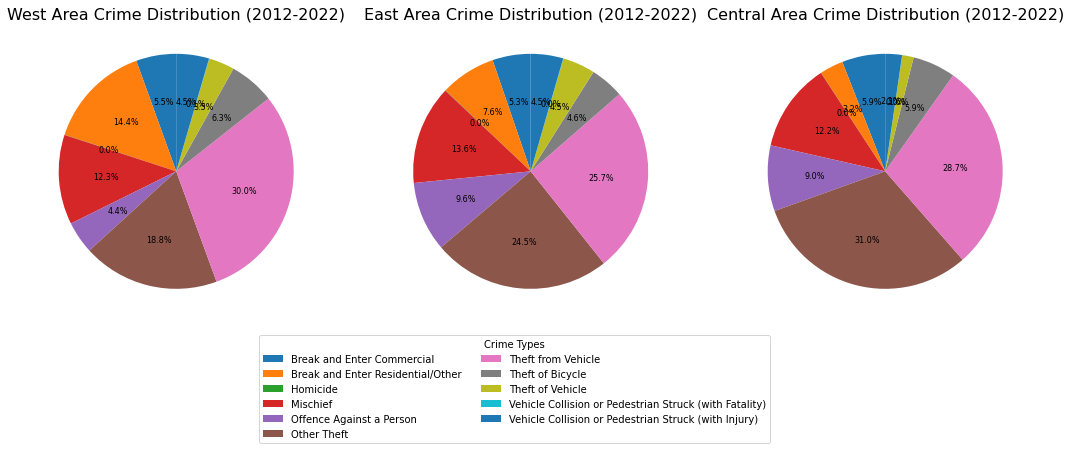

In [16]:
# Group the data by AREA and TYPE of crime
crime_by_area_type = df_12_22.groupby(['AREA', 'TYPE']).size().reset_index(name = 'COUNT')

# Define the areas
areas = ['West', 'East', 'Central']

# Create a figure with multiple pie charts(Three chart in one row)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define the text sizes
percentage_text_size = 8
title_text_size = 16

# Loop through each area and create a pie chart
for index, area in enumerate(areas):
    # Select AREA
    area_data = crime_by_area_type[crime_by_area_type['AREA'] == area]

    # Build the pie chart for this AREA
    wedges, texts, autotexts = axes[index].pie(area_data['COUNT'], autopct='%.1f%%', startangle = 90,
                                               textprops = {'fontsize': percentage_text_size})

    # Set title for this pie chart
    axes[index].set_title(f'{area} Area Crime Distribution (2012-2022)', fontsize = title_text_size)

# Add a legend for all pie charts at the bottom
fig.legend(wedges, area_data['TYPE'], title = "Crime Types", loc = "lower center",
           bbox_to_anchor = (0.5, -0.1), ncol = 2)

# Display the pie charts together with some space for the legend
plt.subplots_adjust(bottom = 0.2)
plt.show()

These three pie charts represent the total of all types of crimes from 2012 to 2022 in the West, East, and Central areas, respectively. From the charts, we can see that regardless of the area, the proportion of "Homicide" and "Vehicle Collision or Pedestrian Struck (with Fatality)" in all types of crimes is very small, almost close to 0.

Since "Other Theft" includes several unknown types of crimes, we will not study and consider this part in the rest of research. Excluding this Type, we find that "Theft from Vehicle" has the highest proportion in each area during these 11 years. At the same time, we can see that "Mischief" has the second-highest proportion in both the East and Central areas. Only in the West area, the proportion of "Break and Enter Residential/other" is greater than "Mischief".

### C) Line Chart

By using line plots, we hope to obtain the general trends of various types of crimes over these 11 years from the charts, as well as to identify any seasonal effects or cyclical influences. In this section, we will present the crime counts on a monthly basis. We will also display the data using two different methods, namely, "Not smoothed" and "smoothed". 

We will show the actual situation through the "Not smoothed" data, while the "smoothed" data will reveal more prominent trends and cyclical patterns. 

We will apply the results from this section to the establishment of time series models later on.

In [17]:
# Build a function to show line plot of each Area
# The input are Area name, Area data frame and lag(use for moving average)
def smooth_crime_plot(area_name, df_area, lag):
    # check wehther the lag is 0
    if lag == 0:
        # Without smoothed
        df_smoothed = df_area.reset_index()
    elif lag > 0:
        # Using moving average by using given lag
        df_smoothed = df_area.groupby(['TYPE']).rolling(window = lag).mean()
        df_smoothed.reset_index(inplace = True)
        
    # Convert the 'DATE' column to datetime format
    df_smoothed['DATE'] = pd.to_datetime(df_smoothed['DATE'], format="%Y-%m")
    
    # Build a color palette with 11 colors(11 crime types)
    num_colors = 11
    color_palette = cm.tab20.colors[:num_colors]
    
    # Build a smoothed time series plot with multiple crime types(without points)
    plt.figure(figsize=(15, 8))
    sns.lineplot(data=df_smoothed, x='DATE', y='COUNT', hue='TYPE', palette=color_palette, estimator='mean')
    
    # Set the axis, label and title
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(12))
    plt.xlabel('Date')
    plt.ylabel('Count')
    # Check whether smoothed
    if lag == 0:
        plt.title(f'Time Series Plot of Different Crime Types in {area_name.capitalize()} Area')
    elif lag > 0:
        plt.title(f'Smoothed: Time Series Plot of Different Crime Types in {area_name.capitalize()} Area')
    plt.legend(title='Crime Type', bbox_to_anchor=(1.01, 1), loc='upper left')
    
    # Show the plot
    plt.show()

#### i) Not smoothed

##### West

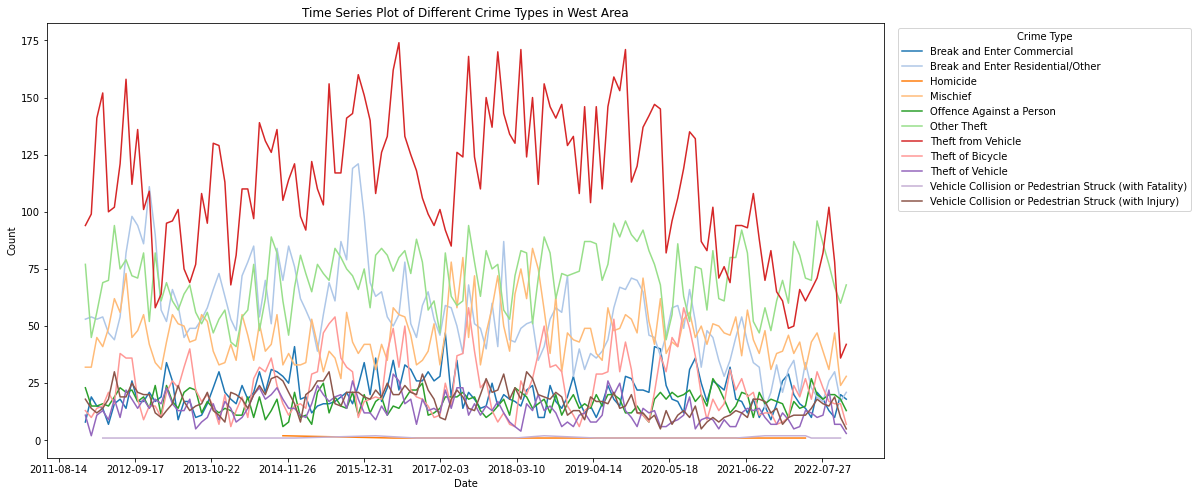

In [18]:
smooth_crime_plot("West", df_west, 0)

##### East

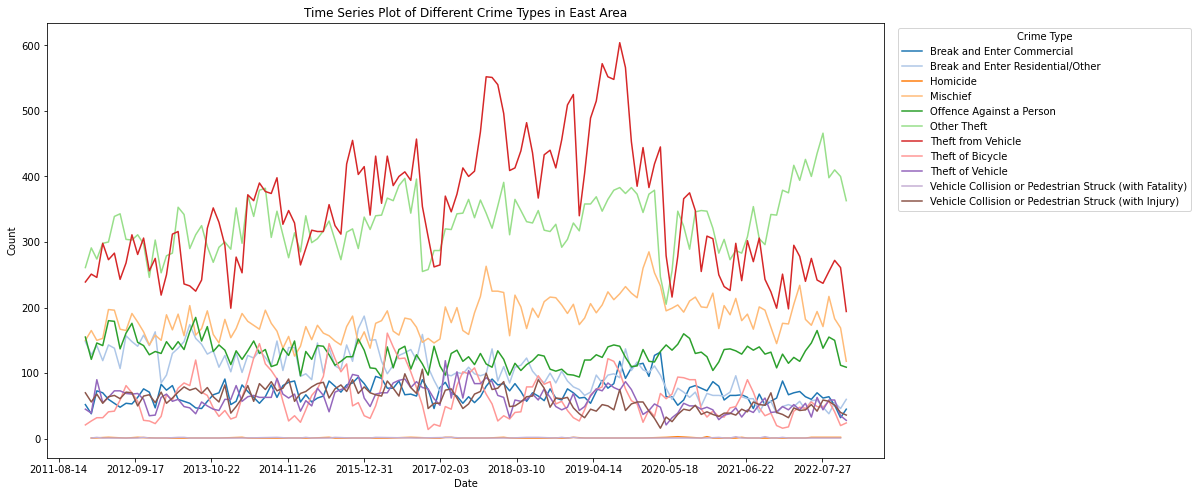

In [19]:
smooth_crime_plot("East", df_east, 0)

##### Central

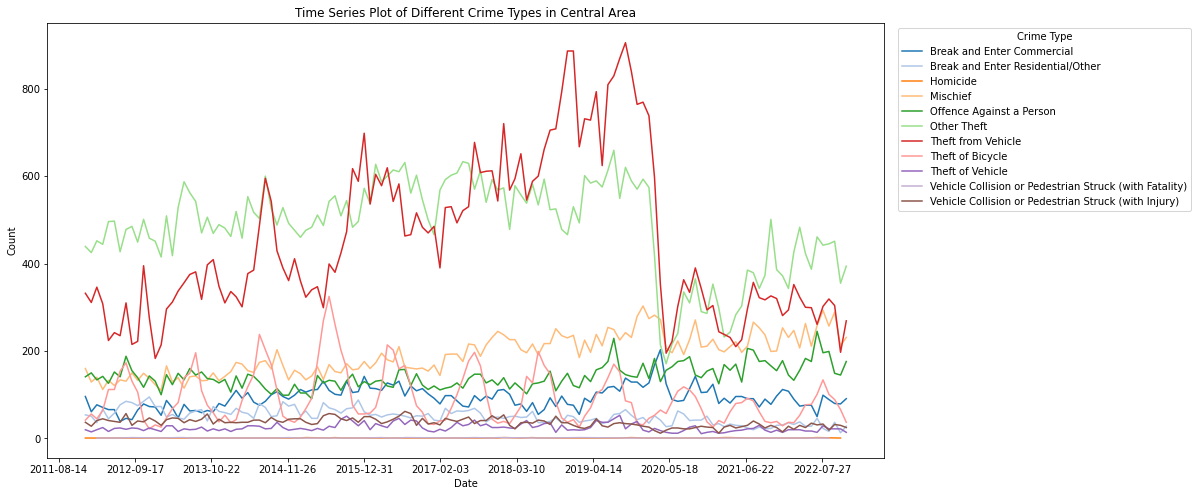

In [20]:
smooth_crime_plot("Central", df_central, 0)

#### ii) Smoothed

The 11-year crime data line plots above are somewhat cluttered due to the large amount of data, making it difficult for us to intuitively observe the changes of each type of crime in each area from 2012 to 2022.

The reasons why we use smoothing because:
+ It helps us reduce the complexity of line plot, allowing for a more intuitive observation of the data trend(Cleveland, 1979).
- It removes random and short-term fluctuations to reduce external interference, allowing for a more intuitive observation of the data long-term seasonal or cyclical effect(Jenkins, Box, & Reinsel, 2011).

Then we choose $lag = 3$ as our input, and we use it for smoothing. 

##### West

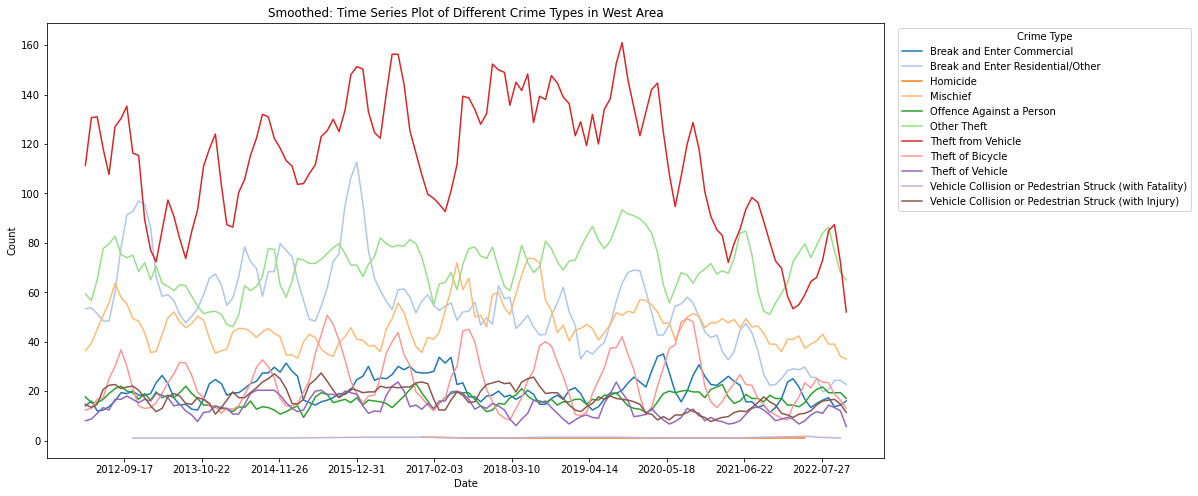

In [21]:
smooth_crime_plot("West", df_west, 3)

From the line plot of the $West$ $area$, we can see that: 
1. The red line representing "Theft from Vehicle" has a significantly higher crime count than other types of crimes. 
2. Except for the period from the end of 2019 to the end of 2022, there is a noticeable downward trend in "Theft from Vehicle". The other types of crimes do not have significant trends. 
3. We can see that most types of crimes have seasonal or cyclical effects. The most obvious is "Theft of Bicycle", which has a clear seasonal effect with a 12-month period.

##### East

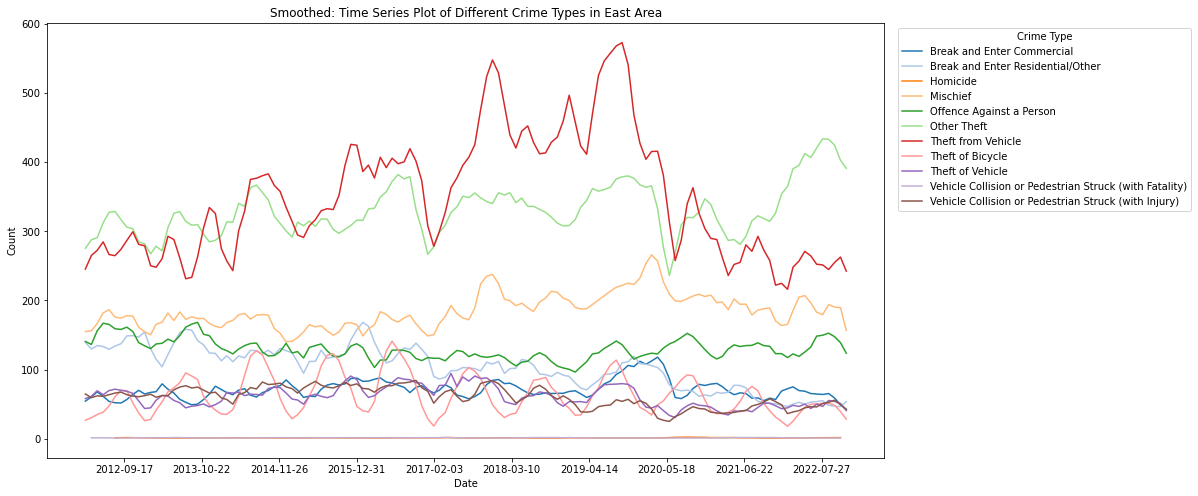

In [22]:
smooth_crime_plot("East", df_east, 3)

From the line plot of the $East$ $area$, we can observe that:
1. The red line representing "Theft from Vehicle" has a significantly higher crime count than other types of crimes (excluding the light green line representing "Other Theft"). 
2. At the end of 2019, there is a cliff-like drop in "Theft from Vehicle", but it gradually stabilizes afterwards. The yellow line representing "Mischief" shows a slow increase from 2012 to the end of 2019, followed by a downward trend. The blue line representing "Break and Enter Residential/Other" displays a declining trend over the 11 years. The other types of crimes do not have significant trends. 
3. We can see that most types of crimes have seasonal or cyclical effects. The most obvious is "Theft of Bicycle", which has a clear seasonal effect with a 12-month cycle.

##### Central

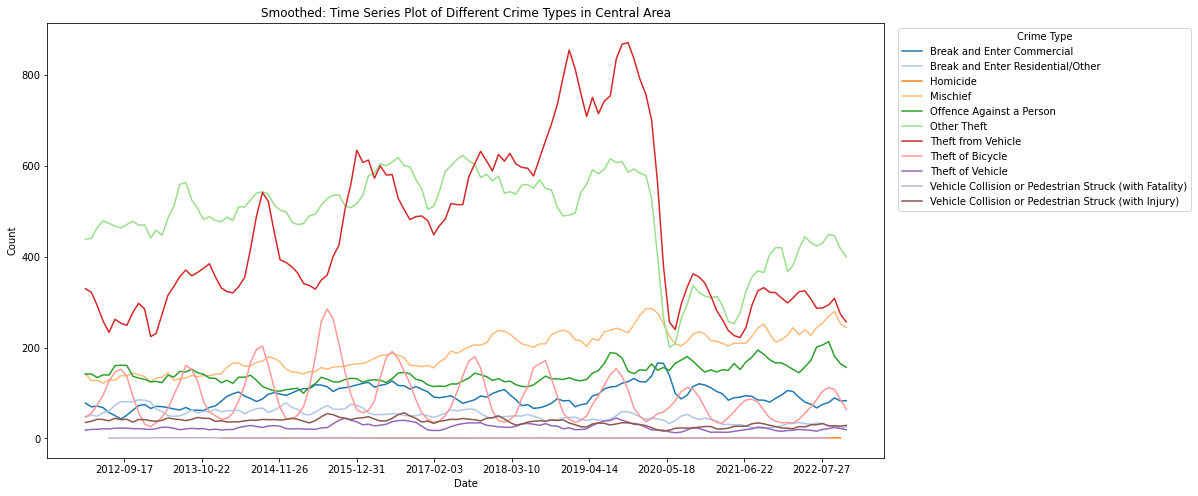

In [23]:
smooth_crime_plot("Central", df_central, 3)

From the line plot of the $Central$ $area$, we can observe that: 
1. The red line representing "Theft from Vehicle" has a significantly higher crime count than other types of crimes (excluding the light green line representing "Other Theft"). 
2. At the end of 2019, there is a cliff-like drop in "Theft from Vehicle". The yellow line representing "Mischief" and the dark green line representing "Offence Against a Person" show an upward trend over these 11 years. By the end of 2022, the crime count of "Mischief" has almost caught up with that of "Theft from Vehicle". The other types of crimes do not have significant trends. 
3. We can see that most types of crimes have seasonal or cyclical effects. The most obvious is still "Theft of Bicycle", which has a clear seasonal effect with a 12-month cycle.

## 5. Building Models to Forecast Future Number of Crimes

### A) Building Models of Theft from Vehicle in the West Area

As we can see from above plots, no matter in which areas, theft from vehicle is the main crime in Vancouver, so we will focus on analyzing this type of crime in this section.

In [24]:
df_west_tv = df_west[df_west['TYPE'] == "Theft from Vehicle"]
df_west_tv.head()

,TYPE,COUNT
DATE,,
2012-1,Theft from Vehicle,94
2012-2,Theft from Vehicle,99
2012-3,Theft from Vehicle,141
2012-4,Theft from Vehicle,152
2012-5,Theft from Vehicle,100


In [25]:
# Get training set and testing set
train = df_west_tv.loc['2012-1':'2021-12'].copy()
test = df_west_tv.loc['2022-1':'2022-12'].copy()

To build a time series model for your data, we should first analyze it to determine which model is appropriate. 
We will separate the data to training set and testing set. The training set is first 10 years data from 2012 to 2021, and the testing set is 1 year data of 2022.

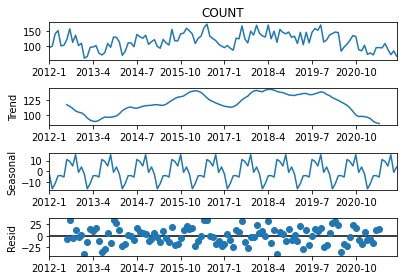

In [26]:
result = seasonal_decompose(train['COUNT'], model='additive', period=12)
fig = result.plot()

# Format x-axis
for ax in fig.axes:
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

In order to build a good model to predict the future number of crimes, we need to make the time series stationary first. The first step is to get rid of the trend and the seasonality. Above plot shows that there is a upward trend and a seasonal effects of period of 12 months.

In [27]:
# Calculate the first difference to make the series stationary
train['COUNT_diff'] = train['COUNT'].diff()
train.dropna(inplace=True)

We take difference to get rid of the trend.

In [28]:
# Perform ADF test to check for stationarity
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

adf_test(train['COUNT_diff'])

ADF Statistic: -7.394135
p-value: 0.000000


This Step is to Check for stationarity: We must ensure that the time series is stationary before modeling. A common test for stationarity is the Augmented Dickey-Fuller (ADF) test.
If the p-value is less than the significance level (0.05), the series is stationary.

We can see that the p-value is 0 which is less than 0,05, then it is stationary.

#### i) ARIMA Model

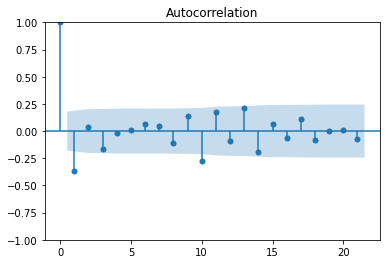

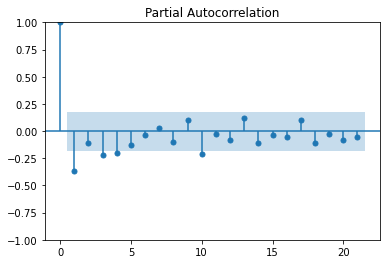

In [29]:
plot_acf(train['COUNT_diff'].dropna())
plot_pacf(train['COUNT_diff'].dropna(), method = 'ywm')
plt.show()

We can see that there is a cut-off at lag 1 in ACF plot, and a cut-off at lag 1 in PACF, so we infer that the model for this time series is ARIMA(1,0,1)(0,0,0)[12]

Mean Squared Error:  571.4209267582033
Mean Absolute Error: 20.240182


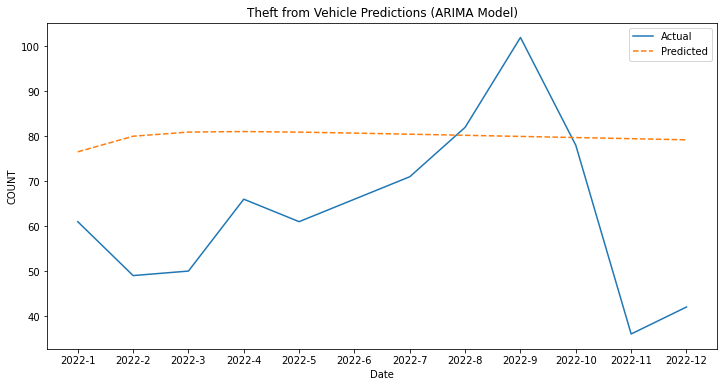

In [30]:
# Ignore warnings
warnings.simplefilter(action='ignore', category=ValueWarning)

# Fit the ARIMA model
model = ARIMA(train['COUNT_diff'], order=(1,0,1), seasonal_order=(0,0,0,12))
model_fit = model.fit()

forecast_diff = model_fit.forecast(steps=len(test))


# Invert the differencing on the forecasted differences to obtain the actual predicted values
forecast = pd.Series(forecast_diff, index=test.index)
forecast = forecast.cumsum() + train['COUNT'].iloc[-1]

# Calculate MSE and MAE
mse = mean_squared_error(test['COUNT'], forecast)
print("Mean Squared Error: ", mse)

mae = mean_absolute_error(test['COUNT'], forecast)
print('Mean Absolute Error: %f' % mae)

plt.figure(figsize=(12, 6))
plt.plot(test['COUNT'], label='Actual')

# Plot the predicted values
plt.plot(forecast, label='Predicted', linestyle='--')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('COUNT')
plt.title('Theft from Vehicle Predictions (ARIMA Model)')
plt.legend()

The MSE (Mean Squared Error) of ARIMA(1,0,1)(0,0,0)[12] is about 571.42. 
The MAE (Mean Absolute Error) of ARIMA(1,0,1)(0,0,0)[12] is about 20.24. 

In the plot we can see that the predicted values are almost linear, but in fact the actual values are non-linear, so we can try to fit other models to improve the precision of our predictions.

#### ii) Exponential Smoothing Method

Mean Squared Error: 364.025088
Mean Absolute Error: 15.492409


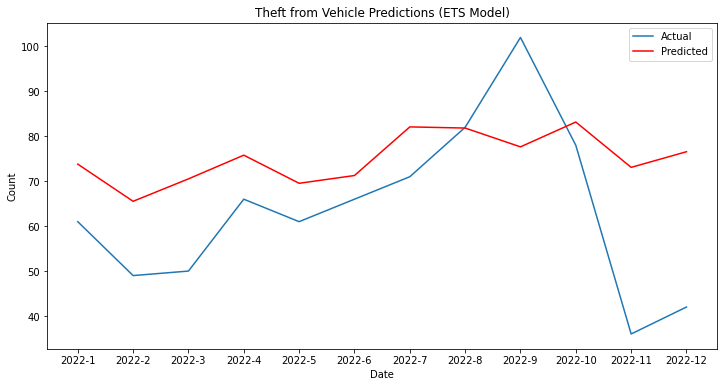

In [31]:
# Fit Exponential Smoothing State Space Model
model = ExponentialSmoothing(train['COUNT'], trend=None, seasonal='multiplicative', seasonal_periods=12)
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.forecast(steps=len(test))

# Calculate Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(test['COUNT'], predictions)
print('Mean Squared Error: %f' % mse)

mae = mean_absolute_error(test['COUNT'], predictions)
print('Mean Absolute Error: %f' % mae)

# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['COUNT'], label='Actual')
plt.plot(test.index, predictions, label='Predicted', color='r')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Theft from Vehicle Predictions (ETS Model)')
plt.legend()
warnings.filterwarnings("ignore")

The MSE of Exponential Smoothing model is about 364.03 and its MAE is 15.49, which is much better than ARIMA model. Also in the plot, the predicted values are much closer to the actual values. 

Therefore, for theft from vehicle in the west area, we prefer Exponential Smoothing model.

### B) Building Models of Theft from Vehicle in the East Area

Let's find out which models have better prediction power: ARIMA model or Exponential Smoothing model.

First, we repeat the same steps in the previous analysis.

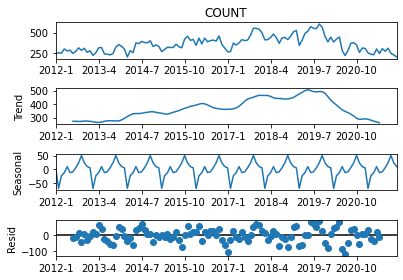

In [32]:
# Get training set and testing set
df_east_tv = df_east[df_east['TYPE'] == "Theft from Vehicle"]
train = df_east_tv.loc['2012-1':'2021-12'].copy()
test = df_east_tv.loc['2022-1':'2022-12'].copy()

# Find trend and seasonality
result = seasonal_decompose(train['COUNT'], model='additive', period=12)
fig = result.plot()
# Format x-axis
for ax in fig.axes:
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

We can see a clear upward trend and seasonality in the training set.

In [33]:
# Get rid of its trend
train['COUNT_diff'] = train['COUNT'].diff()
train.dropna(inplace=True)

# Perform ADF test to check for stationarity
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

adf_test(train['COUNT_diff'])

ADF Statistic: -8.622472
p-value: 0.000000


According to the Augmented Dickey-Fuller (ADF) test, we can see that after we differencing the data, our data becomes stationary.

#### i) ARIMA Model

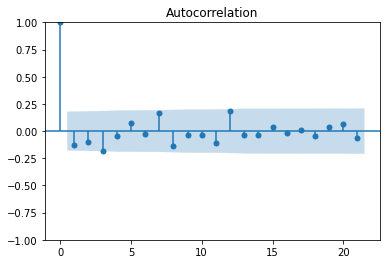

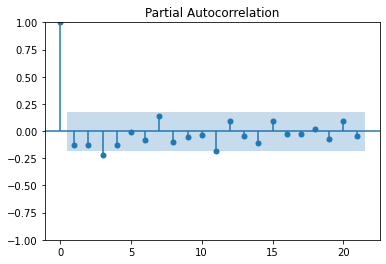

In [34]:
plot_acf(train['COUNT_diff'].dropna())
plot_pacf(train['COUNT_diff'].dropna(), method = 'ywm')
plt.show()

From the plots of ACF and PACF, we can see that both have cut-off at lag 0, so it is hard to determine which ARIMA model to use.

Then I will use auto_arima function to help me determine the parameters of ARIMA model.

In [35]:
best_model= auto_arima(train['COUNT_diff'], seasonal=True, m=12, stepwise=True, suppress_warnings=True, trace=True)
print(best_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=5.20 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1293.971, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1292.440, Time=0.59 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1292.753, Time=1.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1291.975, Time=0.10 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1291.886, Time=0.49 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=1289.729, Time=1.52 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=1291.285, Time=3.09 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1289.522, Time=1.21 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1292.935, Time=0.59 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=1291.370, Time=5.91 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=1290.387, Time=2.08 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=1293.259, Time=4.93 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1289.667, Time=1.70 sec
 ARIMA(0,0,1)(1,0,1)[12]

Mean Squared Error:  2766.312543305016
Mean Absolute Error: 46.272139


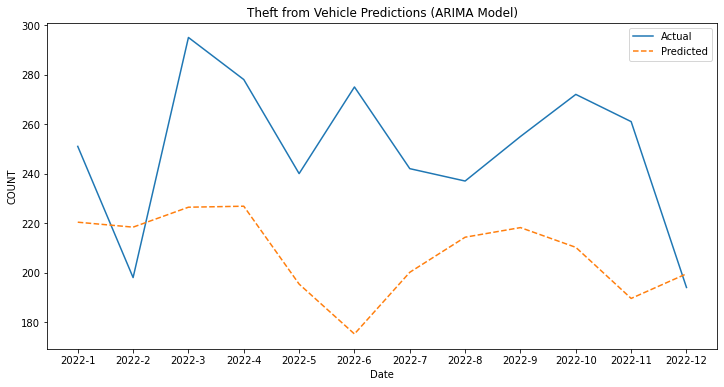

In [36]:
# Fit the best model using the training data
best_model.fit(train['COUNT_diff'])

forecast_diff = best_model.predict(n_periods=len(test))

# Invert the differencing on the forecasted differences to obtain the actual predicted values
forecast = pd.Series(forecast_diff, index=test.index)
forecast = forecast.cumsum() + train['COUNT'].iloc[-1]

# Calculate MSE and MAE
mse = mean_squared_error(test['COUNT'], forecast)
print("Mean Squared Error: ", mse)

mae = mean_absolute_error(test['COUNT'], forecast)
print('Mean Absolute Error: %f' % mae)

plt.figure(figsize=(12, 6))
plt.plot(test['COUNT'], label='Actual')

# Plot the predicted values
plt.plot(forecast, label='Predicted', linestyle='--')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('COUNT')
plt.title('Theft from Vehicle Predictions (ARIMA Model)')
plt.legend()
warnings.filterwarnings("ignore")

#### ii) Exponential Smoothing Method

Mean Squared Error: 3515.474929
Mean Absolute Error: 52.977777


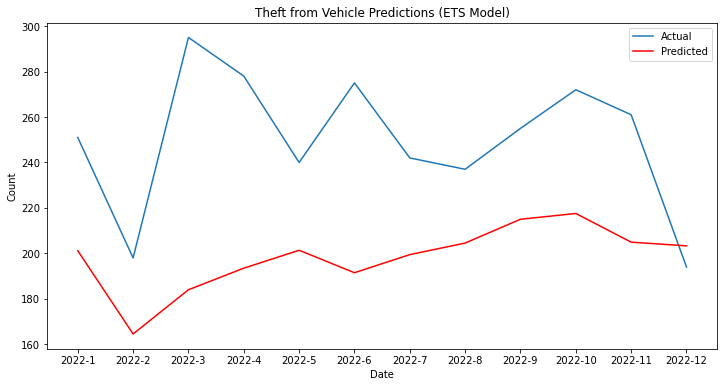

In [37]:
# Fit Exponential Smoothing State Space Model
model = ExponentialSmoothing(train['COUNT'], trend=None, seasonal='mul', seasonal_periods=12)
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.forecast(steps=len(test))

# Calculate Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(test['COUNT'], predictions)
print('Mean Squared Error: %f' % mse)

mae = mean_absolute_error(test['COUNT'], predictions)
print('Mean Absolute Error: %f' % mae)

# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['COUNT'], label='Actual')
plt.plot(test.index, predictions, label='Predicted', color='r')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Theft from Vehicle Predictions (ETS Model)')
plt.legend()
warnings.filterwarnings("ignore")

The MSE of ARIMA model is about 2766.3 and the MSE of Exponential Smoothing model is 3515.5. 

The MAE of ARIMA model is about 46.3 and the MSE of Exponential Smoothing model is 53.0. 

Therefore, Therefore, for theft from vehicle in the east area, we prefer ARIMA(1,0,1)(0,0,2)[12] because it has lower MSE and lower MAE relatively.

### Building Models of Theft from Vehicle in the Central Area

In this section, we will find out which model can better predict the number of thefts from Vehicle in the central area.

We apply the same procedure as previous again.

,TYPE,COUNT
DATE,,
2012-1,Theft from Vehicle,332
2012-2,Theft from Vehicle,311
2012-3,Theft from Vehicle,346
2012-4,Theft from Vehicle,308
2012-5,Theft from Vehicle,224


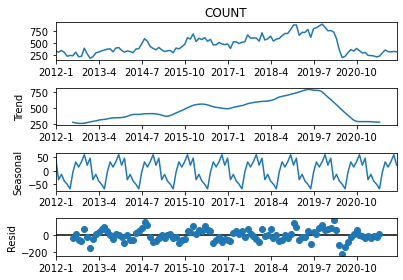

In [38]:
# Get training set and testing set
df_central_tv = df_central[df_central['TYPE'] == "Theft from Vehicle"]
train = df_central_tv.loc['2012-1':'2021-12'].copy()
test = df_central_tv.loc['2022-1':'2022-12'].copy()

# Find trend and seasonality
result = seasonal_decompose(train['COUNT'], model='additive', period=12)
fig = result.plot()
# Format x-axis
for ax in fig.axes:
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
train.head()

We can see a clear upward trend and seasonality in the training set.

In [39]:
# Get rid of its trend
train['COUNT_diff'] = train['COUNT'].diff()
train.dropna(inplace=True)

# Perform ADF test to check for stationarity
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

adf_test(train['COUNT_diff'])

ADF Statistic: -12.258923
p-value: 0.000000


By ADF test, we get p-value of 0, then we can know that the detrended data is stationary.

#### i) ARIMA Model

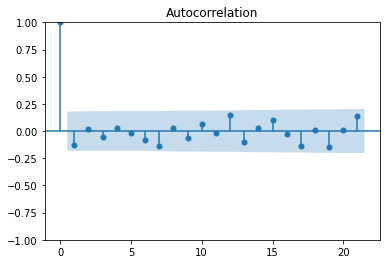

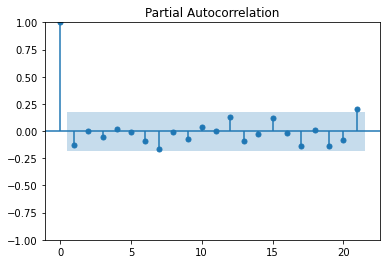

In [40]:
plot_acf(train['COUNT_diff'].dropna())
plot_pacf(train['COUNT_diff'].dropna(), method = 'ywm')
plt.show()

The ACF and PACF  plots are quite same as East area's. Since there is no significant cut-off at any lags in the plots, so we will use auto.arima function again to help us determine the parameters of our ARIMA model. 

In [41]:
best_model= auto_arima(train['COUNT_diff'], seasonal=True, m=12, stepwise=True, suppress_warnings=True, trace=True)
print(best_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=4.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1373.397, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1373.092, Time=0.87 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1373.266, Time=1.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1371.397, Time=0.03 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1372.694, Time=0.48 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1372.918, Time=0.51 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1370.995, Time=1.50 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=1372.994, Time=4.39 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=1376.189, Time=2.40 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=1374.831, Time=1.40 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=1374.150, Time=1.20 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=7.10 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1371.634, Time=2.71 sec
 ARIMA(0,0,1)(1,0,1)[12] inte

Mean Squared Error:  2533.230793329805
Mean Absolute Error: 39.728269


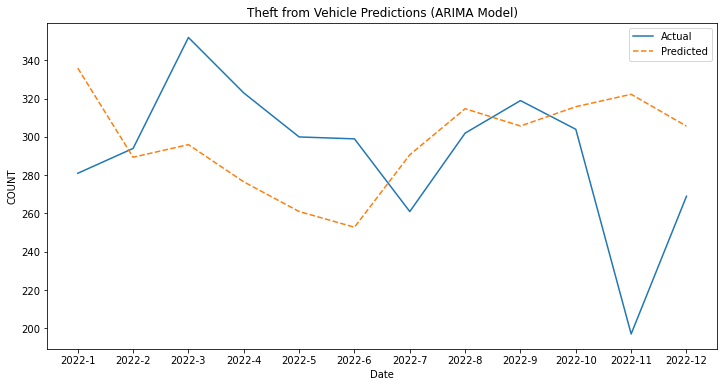

In [42]:
# Fit the best model using the training data
best_model.fit(train['COUNT_diff'])

forecast_diff = best_model.predict(n_periods=len(test))

# Invert the differencing on the forecasted differences to obtain the actual predicted values
forecast = pd.Series(forecast_diff, index=test.index)
forecast = forecast.cumsum() + train['COUNT'].iloc[-1]

# Calculate MSE and MAE
mse = mean_squared_error(test['COUNT'], forecast)
print("Mean Squared Error: ", mse)

mae = mean_absolute_error(test['COUNT'], forecast)
print('Mean Absolute Error: %f' % mae)

# Make plots
plt.figure(figsize=(12, 6))
plt.plot(test['COUNT'], label='Actual')

# Plot the predicted values
plt.plot(forecast, label='Predicted', linestyle='--')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('COUNT')
plt.title('Theft from Vehicle Predictions (ARIMA Model)')
plt.legend()

#### i) Exponential Smoothing Method

Mean Squared Error: 3331.471784
Mean Absolute Error: 48.110393


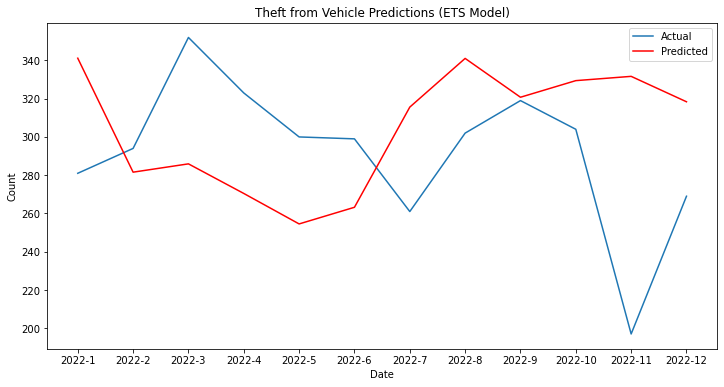

In [43]:
# Fit Exponential Smoothing State Space Model
model = ExponentialSmoothing(train['COUNT'], trend=None, seasonal='mul', seasonal_periods=12)
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.forecast(steps=len(test))

# Calculate Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(test['COUNT'], predictions)
print('Mean Squared Error: %f' % mse)

mae = mean_absolute_error(test['COUNT'], predictions)
print('Mean Absolute Error: %f' % mae)

# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['COUNT'], label='Actual')
plt.plot(test.index, predictions, label='Predicted', color='r')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Theft from Vehicle Predictions (ETS Model)')
plt.legend()
warnings.filterwarnings("ignore")

The MSE of ARIMA model is about 2533.2 and the MSE of Exponential Smoothing model is 3331.5. 

The MAE of ARIMA model is about 39.7 and the MSE of Exponential Smoothing model is 48.1. 

Therefore, for theft from vehicle in the central area, we prefer ARIMA(0,0,0)(1,0,1)[12] because it has lower MSE and lower MAE relatively.

### C) Analysis of model building and model selection

In model building section, we built two different models for theft from vehicle in the three areas of Vancouver. Based on MSE and MAE on the test set, we can do model selection. We choose Exponential Smoothing model for the west area, and ARIMA model for the east area and the central area. 

The differences in the best-fitting models for theft from vehicle in the three areas of Vancouver can be attributed to various factors, including the underlying patterns of criminal activity, local characteristics, and other demographic or socioeconomic factors.

One possible explanation for the different models in each area is that the time series patterns of theft from vehicle in each area might exhibit different levels of seasonality, trend, or noise components. While the Exponential Smoothing model captures the seasonal component more explicitly, the ARIMA model is better at handling trends and noise. In areas where seasonality is more dominant, such as the west area, the Exponential Smoothing model may outperform the ARIMA model. On the other hand, in areas where trend and noise components are more critical, like the east and central areas, the ARIMA model might perform better.

Another factor that could contribute to the difference in the best-fitting models is socioeconomic factors. A study by Andresen and Linning found that crime patterns in Vancouver can be influenced by different socioeconomic factors across neighborhoods, leading to differences in the distribution of crime types(Andresen & Linning, 2012). Understanding these factors can help to explain why different models might be preferred for predicting theft from vehicle crimes in different areas of Vancouver.

## 6. Empirical Analysis

## 7. Limitation

## 8. Discussion

## 9. Conclusion

## 10. References

Cleveland, W. S. (1979). Robust locally weighted regression and smoothing scatterplots. Journal of the American statistical association, 74(368), 829-836.

Jenkins, G. M., Box, G. E., & Reinsel, G. C. (2011). Time series analysis: forecasting and control (Vol. 734). John Wiley & Sons.

Andresen, M. A., & Linning, S. J. (2012). The (in)appropriateness of aggregating across crime types. Applied Geography, 35(1-2), 275-282.